# Сборный проект 2

# Восстановление золота из руды

На основании данных о добыче и очистке руды необходимо подготовить модель машинного обучения, предсказывающую коэффициент восстановления золота из золотосодержащей руды.

## Содержание


1. [Подготовка данных](#introduction) <br>
   1.1 [Описание данных](#subparagraph1) <br>
   1.2 [Импорт библиотек](#subparagraph2) <br>
   1.3 [Изучение данных](#subparagraph3) <br>
   1.4 [Проверка правильности расчета эффективности обогащения](#subparagraph4) <br> 
   1.5 [Анализ признаков, недоступных в тестовой выборке](#subparagraph5) <br> 
   1.6 [Предобработка данных](#subparagraph6) <br>
2. [Анализ данных](#paragraph2) <br>
   2.1 [Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки](#subparagraph7) <br>
   2.2 [Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#subparagraph8) <br>
   2.3 [Исследование суммарной концентрации веществ на разных стадиях](#subparagraph9) <br>
3. [Модель](#paragraph3) <br>
   3.1 [Написание функции для расчета  sMAPE](#subparagraph10) <br>
   3.2 [Обучение и оценка качества моделей](#subparagraph11) <br>
   3.3 [Проверка модели на тестовой выборке](#subparagraph12) <br>
   3.4 [Проверка модели на адекватность](#subparagraph13) <br>
4. [Общий вывод](#paragraph3) <br>

### 1.1 Описание данных
<a name="subparagraph1"></a>

**Технологический процесс** <br>

•	Rougher feed — исходное сырье <br>
•	Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant <br>
o	Xanthate **— ксантогенат (промотер, или активатор флотации); <br>
o	Sulphate — сульфат (на данном производстве сульфид натрия); <br> 
o	Depressant — депрессант (силикат натрия). <br> 
•	Rougher process (англ. «грубый процесс») — флотация <br> 
•	Rougher tails — отвальные хвосты <br> 
•	Float banks — флотационная установка <br>
•	Cleaner process — очистка <br>
•	Rougher Au — черновой концентрат золота <br>
•	Final Au — финальный концентрат золота <br>

**Параметры этапов** <br>

•	air amount — объём воздуха <br>
•	fluid levels — уровень жидкости <br>
•	feed size — размер гранул сырья <br>
•	feed rate — скорость подачи <br>

**Наименование признаков** <br>
Наименование признаков должно быть такое: <br>
[этап].[тип_параметра].[название_параметра] <br>
Пример: rougher.input.feed_ag <br>

*Возможные значения для блока [этап]:* <br>
•	rougher — флотация <br>
•	primary_cleaner — первичная очистка <br>
•	secondary_cleaner — вторичная очистка <br>
•	final — финальные характеристики <br>

*Возможные значения для блока [тип_параметра]:* <br>
•	input — параметры сырья <br>
•	output — параметры продукта <br>
•	state — параметры, характеризующие текущее состояние этапа <br>
•	calculation — расчётные характеристики <br>

### 1.2 Импорт библиотек
<a name="subparagraph2"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, KFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, mean_absolute_error, make_scorer, make_scorer

### 1.3 Изучение данных
<a name="subparagraph3"></a>

Откроем данные

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

Посмотрим на размеры выборок

In [3]:
data = {'исходные данные' : full, 'обучающая выборка' : train, 'тестовая выборка' : test}

for key, value in data.items():
    print(key + ':', value.shape)

исходные данные: (22716, 87)
обучающая выборка: (16860, 87)
тестовая выборка: (5856, 53)


Отметим, что размерность столбцов тестовой выборки отличается от размерности столбцов исходных данных и обучающей выборки. Количество столбцов в тестовой выборке на 26 меньше, чем в обучающей. 

Выведем первые пять строк датасетов 

In [4]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Посмотрим на общую информацию по каждому датасету.

Выведем информацию об обучающем датасете

In [7]:
train.info()
display(train.shape)
print('Количество полных дубликатов:', sum(train.duplicated()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

(16860, 87)

Количество полных дубликатов: 0


Обучающая выборка включает в себя 16860 объектов и 87 признаков. <br>
Выведем информацию о тестовой выборке.

In [8]:
print(test.info())
test.shape
print('Количество полных дубликатов:', sum(test.duplicated()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Тестовая выборка включает в себя 5856 объектов и 52 признака.<br>
Выведем информацию об исходных данных

In [9]:
print(full.info())
full.shape
print('Количество полных дубликатов:', sum(full.duplicated()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Исходная выборка включает в себя 22176 объектов и 86 признаков.

Результаты первичного анализа выборок: <br>
- во всех выборках все признаки количественные, категориальные признаки отсутствуют; <br>
- полные дубликаты отсутствуют в данных; <br>
- в каждом датасете в ряде столбцов наблюдается значительное количество пропусков - нужно будет детальнее изучить процент пропусков по каждому признаку и понять, каким образом их заполнять или удалять; <br>
- в процессах флотации и очистки участвует несколько флотационных установок; <br> 
- в дальнейшем необходимо изменить формат даты с 'object' на 'datetime'.

In [10]:
#перенесем значения даты в индекс и создадим дополнительй столбец с измененным форматом даты
train['date_time'] = train['date']
test['date_time'] = test['date']
full['date_time'] = full['date']
#приведем значения в новых столбцах к формату 'datetime'
train['date_time'] = pd.to_datetime(train['date_time'], format = '%Y-%m-%dT%H:%M:%S')
test['date_time'] = pd.to_datetime(test['date_time'], format = '%Y-%m-%dT%H:%M:%S')
full['date_time'] = pd.to_datetime(full['date_time'], format = '%Y-%m-%dT%H:%M:%S')
#переведем столбец 'date' в индекс
train = train.set_index('date')
test = test.set_index('date')
full = full.set_index('date')

### 1.4 Проверка правильности расчета эффективности обогащения 
**Рассчитаем эффективность обогащения на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчетами и зачением признака.**
<a name="subparagraph4"></a>

Формула расчета эффективности обогащения: 

$$ Recovery = \frac{C × (F-T)}{F × (C-T)} × 100%$$

где: 

- C — доля золота в концентрате после флотации/очистки
- F — доля золота в сырье/концентрате до флотации/очистки
- T — доля золота в отвальных хвостах после флотации/очистки.

Поскольку мы рассчитываем эффективность обогащения на этапах до и после флотации, посмотрим на список признаков, в названии которых присутствует "recovery".

In [11]:
train_copy = train.copy(deep=True)
for col in train_copy.columns:
    if 'rougher' in col:
        print(col)

rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.input.feed_ag
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.feed_au
rougher.input.floatbank10_sulfate
rougher.input.floatbank10_xanthate
rougher.input.floatbank11_sulfate
rougher.input.floatbank11_xanthate
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
rougher.state.floatbank10_a_air
rougher.state.floatbank10_a_level
rougher.state.floatbank10_b_air
rougher.state.floatbank10_b_level
rougher.state.floatbank10_c_air
rougher.state.floatbank10_c_level
rougher.state.floatbank10_d_air
rougher.state.floatbank10_d_level
rougher.state.floatbank10_e_air
rougher.sta

В целях расчета эффективности обогащения будем использовать следующие признаки: 
- rougher.output.concentrate_au — доля золота в концентрате после флотации/очистки (C); <br>
- rougher.input.feed_au — доля золота в сырье/концентрате до флотации/очистки (F); <br>
- rougher.output.tail_au — доля золота в отвальных хвостах после флотации/очистки (T). <br>

Создадим столбец с рассчитанным коэффициентом восстановления

In [12]:
train_copy['rougher.output.recovery.calculated'] = (train_copy['rougher.output.concentrate_au'] * (train_copy['rougher.input.feed_au'] - train_copy['rougher.output.tail_au']))/(train_copy['rougher.input.feed_au']*(train_copy['rougher.output.concentrate_au'] - train_copy['rougher.output.tail_au']))*100
train_copy['rougher.output.recovery.calculated'].head(3)

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
Name: rougher.output.recovery.calculated, dtype: float64

Рассчитаем MAE между рассчитанными значениями 'rougher.output.recovery.calculated' и значениями признака 'rougher.output.recovery'.

Удалим пропуски в данных

In [13]:
train_copy.dropna(inplace = True)
print('MAE между рассчитанным и заданным признаком составляет:', mean_absolute_error(train_copy['rougher.output.recovery'], train_copy['rougher.output.recovery.calculated']))


MAE между рассчитанным и заданным признаком составляет: 9.555596961987514e-15


Получено крайне малое значение MAE, что свидетельствует о том, что эффективность обогащения рассчитана верно.

### 1.5 Анализ признаков, недоступных в тестовой выборке
<a name="subparagraph5"></a>

Проверим, какие из признаков, доступных в обучающей выборке, отсутствуют в тестовой выборке

In [14]:
print('Количество признаков отсутствующих в тестовой выборке:', len(set(train) - set(test)))

Количество признаков отсутствующих в тестовой выборке: 34


Посмотрим на список отсутствующих признаков

In [15]:
set(train) - set(test)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют признаки, характеризующие параметры продукта ('output') и расчетные характеристики ('calculation'). Кроме того, в тестовой выборке отсутствуют целевые признаки, поскольку, согласно условию, они замеряются гораздо позже: 
- final.output.recovery - эффективность обогащения финального концентрата;
- rougher.output.recovery - эффективность обогащения чернового концентрата. 

Поскольку выходные данные о продукте и его расчетные характеристики становятся доступными только после измерения целевых признаков, их нецелесообразно включать в выборку для обучения модели. Следовательно, их можно не подтягивать из исходного датасета. <br>
Отсутствующие целевые признаки восстановим из исходного датасета. <br>

### 1.6 Предобработка данных ###
<a name="subparagraph6"></a>

Создадим копии выборок

In [16]:
full_rep = full.copy(deep=True)
train_rep = train.copy(deep=True)
test_rep = test.copy(deep=True)

Проанализируем пропущенные значения в каждом датасете

In [17]:
full_rep.isna().sum().sort_values(ascending=False)

rougher.output.recovery                     3119
rougher.output.tail_ag                      2737
rougher.output.tail_au                      2736
rougher.output.tail_sol                     2736
rougher.input.floatbank11_xanthate          2257
                                            ... 
primary_cleaner.state.floatbank8_c_level      43
primary_cleaner.state.floatbank8_d_level      43
primary_cleaner.state.floatbank8_b_level      43
primary_cleaner.input.feed_size                0
date_time                                      0
Length: 87, dtype: int64

In [18]:
train_rep.isna().sum().sort_values(ascending=False)

rougher.output.recovery                          2573
rougher.output.tail_ag                           2250
rougher.output.tail_au                           2249
rougher.output.tail_sol                          2249
secondary_cleaner.output.tail_sol                1986
                                                 ... 
rougher.calculation.sulfate_to_au_concentrate      27
primary_cleaner.state.floatbank8_d_level           27
primary_cleaner.state.floatbank8_b_level           27
primary_cleaner.input.feed_size                     0
date_time                                           0
Length: 87, dtype: int64

In [19]:
test_rep.isna().sum().sort_values(ascending=False)

rougher.input.floatbank11_xanthate            353
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
rougher.input.floatbank10_sulfate             257
primary_cleaner.input.xanthate                166
rougher.input.floatbank10_xanthate            123
rougher.input.feed_sol                         67
rougher.input.floatbank11_sulfate              55
rougher.input.feed_rate                        40
secondary_cleaner.state.floatbank3_a_air       34
secondary_cleaner.state.floatbank2_b_air       23
rougher.input.feed_size                        22
secondary_cleaner.state.floatbank2_a_air       20
rougher.state.floatbank10_a_air                17
rougher.state.floatbank10_b_air                17
rougher.state.floatbank10_d_air                17
rougher.state.floatbank10_e_air                17
rougher.state.floatbank10_f_air                17
rougher.state.floatbank10_c_air                17
rougher.state.floatbank10_f_level              16


Наибольшее количество пропущенных значений в целевом признаке - 'rougher.output.recovery'

Удалим строки с пропусками в целевых признаках.

In [20]:
full_rep.dropna(subset= ['rougher.output.recovery', 'final.output.recovery'], inplace=True)
train_rep.dropna(subset= ['rougher.output.recovery', 'final.output.recovery'], inplace=True)

Т.к. согласно условию проекта, соседние по времени параметры часто похожи, пропуски в остальных признаках заполним ближайшими значениями. 

In [21]:
full_rep = full_rep.fillna(method = 'ffill')
train_rep = train_rep.fillna(method = 'ffill')
test_rep = test_rep.fillna(method = 'ffill')

Проверим остались ли пропуски в данных

In [22]:
full_rep.isna().sum().unique()

array([0])

In [23]:
train_rep.isna().sum().unique()

array([0])

In [24]:

test_rep.isna().sum().unique()

array([0])

Подтянем столбцы с целевыми признаками из исходного датасета в тестовый датасет. Соответствие установим на основании индекса.

In [25]:
test_rep = test_rep.join(full_rep['rougher.output.recovery'])

In [26]:
test_rep = test_rep.join(full_rep['final.output.recovery'])

In [27]:
test_rep.head(5)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,date_time,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,2016-09-01 01:59:59,88.089657,68.910432
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,2016-09-01 02:59:59,88.412756,68.143213
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,2016-09-01 03:59:59,87.360133,67.776393
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,2016-09-01 04:59:59,83.236367,61.467078


Проверим, образовались ли пропуски в целевых переменных при их присоединении в тестовую выборку

In [28]:
test_rep.isna().sum().sort_values(ascending = False)

final.output.recovery                         566
rougher.output.recovery                       566
primary_cleaner.input.depressant                0
primary_cleaner.input.feed_size                 0
rougher.state.floatbank10_b_level               0
rougher.state.floatbank10_b_air                 0
rougher.state.floatbank10_a_level               0
rougher.state.floatbank10_a_air                 0
rougher.input.floatbank11_xanthate              0
rougher.input.floatbank11_sulfate               0
rougher.input.floatbank10_xanthate              0
rougher.input.floatbank10_sulfate               0
rougher.input.feed_au                           0
rougher.input.feed_sol                          0
rougher.input.feed_size                         0
rougher.input.feed_rate                         0
rougher.state.floatbank10_c_air                 0
rougher.input.feed_ag                           0
primary_cleaner.state.floatbank8_d_level        0
primary_cleaner.state.floatbank8_d_air          0


Удалим обнаруженные пропуски в целевых переменных

In [29]:
test_rep.dropna(subset= ['rougher.output.recovery', 'final.output.recovery'], inplace=True)

Посмотрим на размерность обучающей и тестовой выборки

In [30]:
train_rep.shape

(14149, 87)

In [31]:
test_rep.shape

(5290, 55)

Как ранее было обнаружено, с учетом добавления целевых признаков, в тестовой выборке на 32 признака меньше, чем в обучающей выборке. 

Для соответствия количества признаков при обучении моделей оставим в обучающей выборке только те признаки, которые присутствуют в тестовой выборке. Как ранее отмечалось, в тестовой выборке, кроме целевых признаков, отсутствуют признаки, которые рассчитываются уже после измерения целевых признаков - следовательно, не имеет смысла на них обучать модель, т.е. их также следует исключить из обучающей выборки.

In [32]:
test_columns = list(test_rep.columns)
train_rep = train_rep[test_columns]

Вновь проверим размерность тестовой и обучающей выборок.

In [33]:
train_rep.shape

(14149, 55)

In [34]:
test_rep.shape

(5290, 55)

Произведем финальную проверку на соответствие перечня признаков в обучающей и тестовой выборках. 

In [35]:
list(set(train_rep.columns.tolist()) - set(test_rep.columns.tolist()))

[]

In [36]:
list(set(test_rep.columns.tolist()) - set(train_rep.columns.tolist()))

[]

Предобработка данных завершена.

Результаты предобработки данных: <br>
1. Данные об эффективности обогащения, сохраненные в переменной 'rougher.output.recovery' в обучающей выборке, рассчитаны верно, поскольку при ее сравнении с коэффициентом обогащения, рассчитанным на основании данных, метрика средней абсолютной ошибки демонстрирует низкое значение. <br>
2. Пропуски в целевых переменных во всех датасетах была удалены, в остальных признаках - заполнены соседними значениями с помощью функции ffill. <br>
3. В тестовую выборку были добавлены отсутствующие целевые признаки из исходной выборки с соответствующим индексом. <br>
3. В обучающей выборке были оставлены только те признаки, которые присутствуют в тестовой выборке. В результате в тестовой выборке было удалено 32 признака. Таким образом, датасет с тестовой и обучающей выборками готовы для построения моделей.   <br> 


## 2. Анализ данных
<a name="paragraph2"></a>

### 2.1 Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки
<a name="subparagraph7"></a>

Анализ данных будет производиться на исходном датасете. Необходимо посмотреть на изменение концентрации металлов на следующих этапах обработки руды: <br>
- сырье до обработки <br>
- сырье после флотации <br>
- сырье после первого этапа очистки <br>
- сырье после второго этапа очистки <br>

Выведем список колонок, содержащих в названии 'concentrate' и 'rougher.input.feed_'

In [37]:
all_full = full_rep.columns.tolist()
conc = [col for col in all_full if 'concentrate' in col]
feed  = [col for col in all_full if 'rougher.input.feed' in col]
conc_feed = conc + feed
final_col = [col for col in conc_feed if 'au' in col or 'ag' in col or 'pb' in col]

Вывели все необходимые признаки за исключением отношения сульфата к золоту - удалим его из перечня признаков

In [38]:
final_col.remove('rougher.calculation.sulfate_to_au_concentrate')

Расположим перечень признаков в обратном порядке в соответствии с этапами обработки.

In [39]:
final_col.reverse()
final_col

['rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_ag']

Создадим датафреймы для каждого метала, включающие в себя все этапы обработки.

In [40]:
ag_columns = [col for col in final_col if 'ag' in col]
au_columns = [col for col in final_col if 'au' in col]
pb_columns = [col for col in final_col if 'pb' in col]

In [41]:
ag = full_rep[ag_columns]
au = full_rep[au_columns]
pb = full_rep[pb_columns]

In [42]:
def concentration_stages(metal, name):
    
    sns.set(style ='whitegrid')
    
    fig, ax = plt.subplots(4,1, sharex=True, sharey=True, figsize=(14,9))
    columns = metal.columns
    colors = ['blue', 'yellow', 'red', 'green']
    
    for i in range(len(columns)):
        
        sns.distplot(a=metal.iloc[:,i], ax=ax[i], color=colors[i], kde=True)
        ax[i].set_xlabel(columns[i])
        ax[i].set_ylabel('')
        
    fig.suptitle('Распределение концентрации {} на различных этапах технологического процесса'.format(name), size=16, y=(0.94))
    fig.show()

Посмотрим на концентрацию серебра на каждом этапе технологического процесса

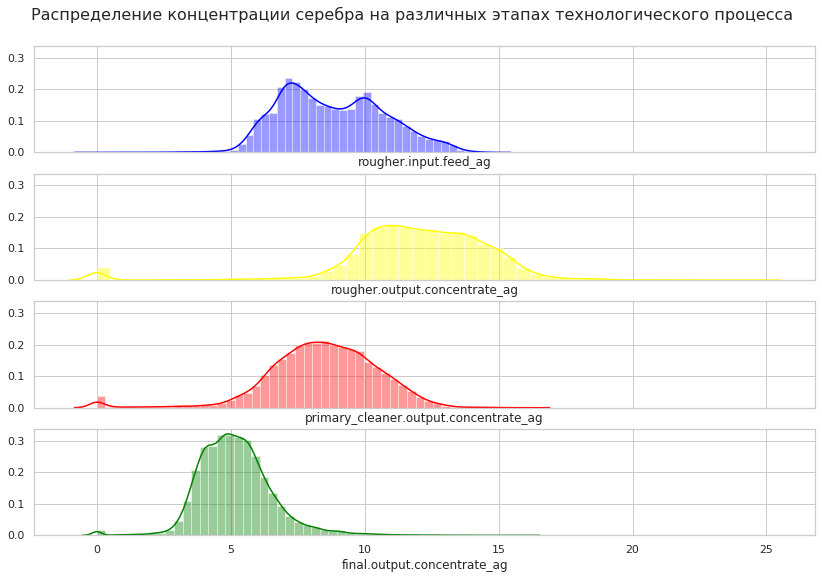

In [43]:
concentration_stages(ag, 'серебра')

Посмотрим на концентрацию золота на каждом этапе технологического процесса

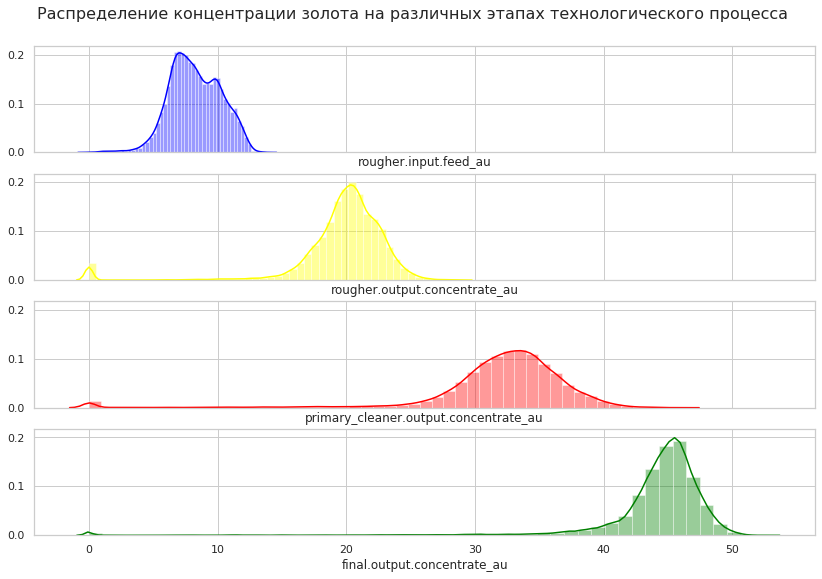

In [44]:
concentration_stages(au, 'золота')

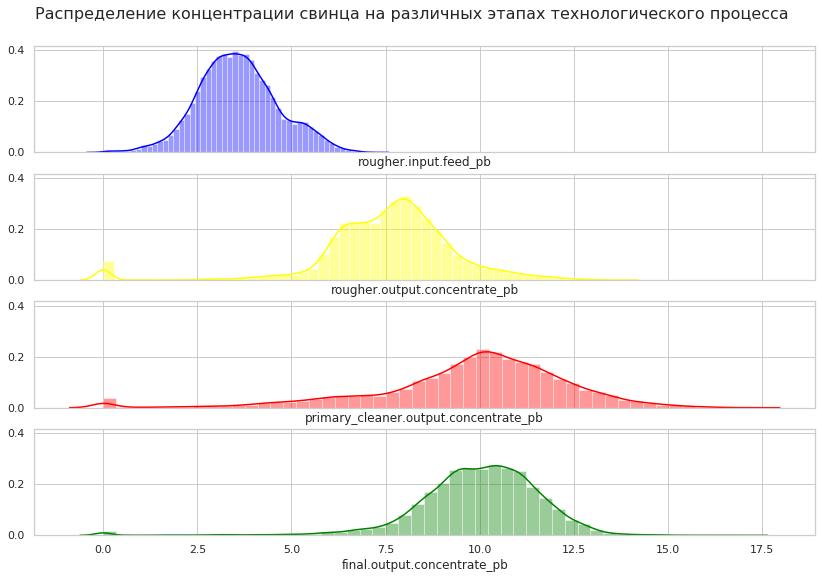

In [45]:
#посмотрим на концентрацию свинца на каждом этапе технологического процесса
concentration_stages(pb, 'свинца')

**Выводы** <br>
    
Коцентрация в зависимости от вида металла меняется на каждом этапе технологического процесса. <br>

1) Концентрация серебра (Ag): <br>
- снижается с каждым последующим этапом очистки; <br>
- достигает максимального значения на втором этапе; <br>
    
2) Концентрация золота (Au): <br>
- увеличивается с каждым последующим этапом технологического процесса; <br>
- достигает максимального значения на последнем этапе; <br>
    
3) Концентрация свинца (Pb): <br>
- в течение первых трех этапов увеличивается; <br>
- на последней стадии снижается разброс значений концентрации. <br>

Распределение концентрации всех видов металлов характеризуется толстыми хвостами, что указывает на наличие выбросов. 
</div>

### 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках
<a name="subparagraph8"></a>

Для сравнения распределения размеров гранул сырья на обучающей и тестовой выборках посмотрим на признаки, в названии которых присутствует параметр 'feed_size'.


In [46]:
train_rep_cols = train_rep.columns.tolist()
feed_size = [col for col in train_rep_cols if 'feed_size' in col]
feed_size

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

Мы можем наблюдать размеры сырья перед этапом использования флотационной установки и перед первичной очисткой сырья.

In [47]:
feed_size_train = train_rep[feed_size]
feed_size_test = test_rep[feed_size]

Посмотрим на распределение размера гранул сырья перед попаданием во флотационную установку.

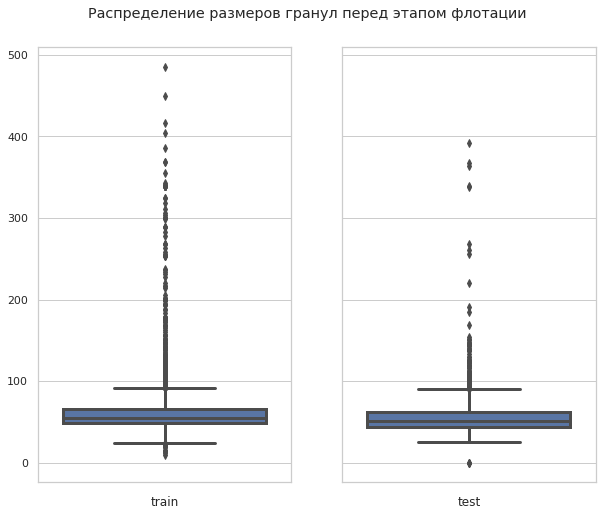

In [48]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,8))
sns.boxplot(y='rougher.input.feed_size', linewidth=3, data=feed_size_train, ax=ax[0])
ax[0].set_xlabel('train')
ax[0].set_ylabel('')
sns.boxplot(y='rougher.input.feed_size', linewidth=3, data=feed_size_test, ax=ax[1])
ax[1].set_xlabel('test')
ax[1].set_ylabel('')
plt.suptitle('Распределение размеров гранул перед этапом флотации', y=0.95);

Наблюдаем значительное количество выбросов. Удалим выбросы для более четкого отображения диаграмм размаха. 

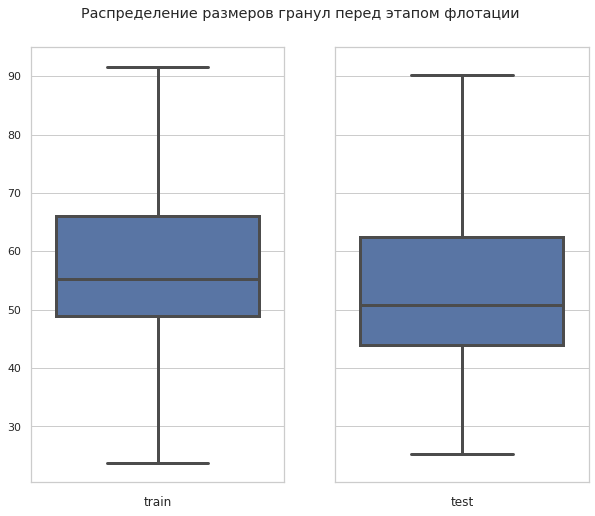

In [49]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,8))
sns.boxplot(y='rougher.input.feed_size', linewidth=3, data=feed_size_train, ax=ax[0], showfliers=False)
ax[0].set_xlabel('train')
ax[0].set_ylabel('')
sns.boxplot(y='rougher.input.feed_size', linewidth=3, data=feed_size_test, ax=ax[1], showfliers=False)
ax[1].set_xlabel('test')
ax[1].set_ylabel('')
plt.suptitle('Распределение размеров гранул перед этапом флотации', y=0.95);

Средние значения на тренировочной и тестовой выборках находятся между первым и третим квартилями, что указывает на приблизительно равное распределение гранул на тестовой и обучающей выборках. 

Посмотрим на распределение размера гранул сырья перед первым этапом очистки сырья. 

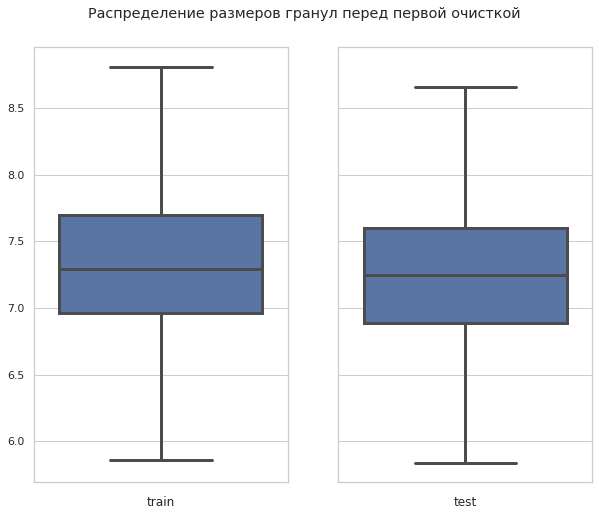

In [50]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,8))
sns.boxplot(y='primary_cleaner.input.feed_size', linewidth=3, data=feed_size_train, ax=ax[0], showfliers=False)
ax[0].set_xlabel('train')
ax[0].set_ylabel('')
sns.boxplot(y='primary_cleaner.input.feed_size', linewidth=3, data=feed_size_test, ax=ax[1], showfliers=False)
ax[1].set_xlabel('test')
ax[1].set_ylabel('')
plt.suptitle('Распределение размеров гранул перед первой очисткой', y=0.95);

Диаграммы размаха указывают на то, что размеры гранул сырья на тестовой и обучающей выборках имеют близкое друг к другу распределение. 

**Выводы** <br>
    
В данном блоке в результате визуализации распределения размеров гранул сырья на тестовой и обучающей выборках было выявлено сходство распределений для двух датасетов как на этапе перед флотацией, так и перед первой очисткой. 

### 2.3 Исследование суммарной концентрации веществ на разных стадиях

**Проанализируем суммарную концентрацию всех веществ в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.**
<a name="subparagraph9"></a>

Выведем на экран признаки, характеризующие концентрацию веществ на каждом этапе технологического процесса

In [51]:
final_col

['rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_ag']

Создадим в исходном датасете столбцы, характеризующие суммарную концентрацию веществ (Au, Ag, Pb) на каждом этапе технологического процесса. 

In [52]:
full_rep['rougher_input'] = full_rep[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
full_rep['rougher_output'] = full_rep[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
full_rep['primary_cleaner'] = full_rep[['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb']].sum(axis=1)
full_rep['final'] = full_rep[['final.output.concentrate_au','final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

In [53]:
full_rep.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,date_time,rougher_input,rougher_output,primary_cleaner,final
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,-498.310211,8.079666,-500.470978,14.151341,-605.841980,2016-01-15 00:00:00,14.871440,38.395653,53.111627,58.137072
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,-500.169983,7.984757,-500.582168,13.998353,-599.787184,2016-01-15 01:00:00,14.905729,38.945647,53.174338,58.699942
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,-500.129135,8.013877,-500.517572,14.028663,-601.427363,2016-01-15 02:00:00,14.638299,38.649756,52.927464,58.927421
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,-499.201640,7.977324,-500.255908,14.005551,-599.996129,2016-01-15 03:00:00,14.199305,38.411473,43.979185,58.714815
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,-501.686727,7.894242,-500.356035,13.996647,-601.496691,2016-01-15 04:00:00,13.511497,38.867359,52.121146,59.065251


Построим диаграмму размаха для четырех этапов обогащения

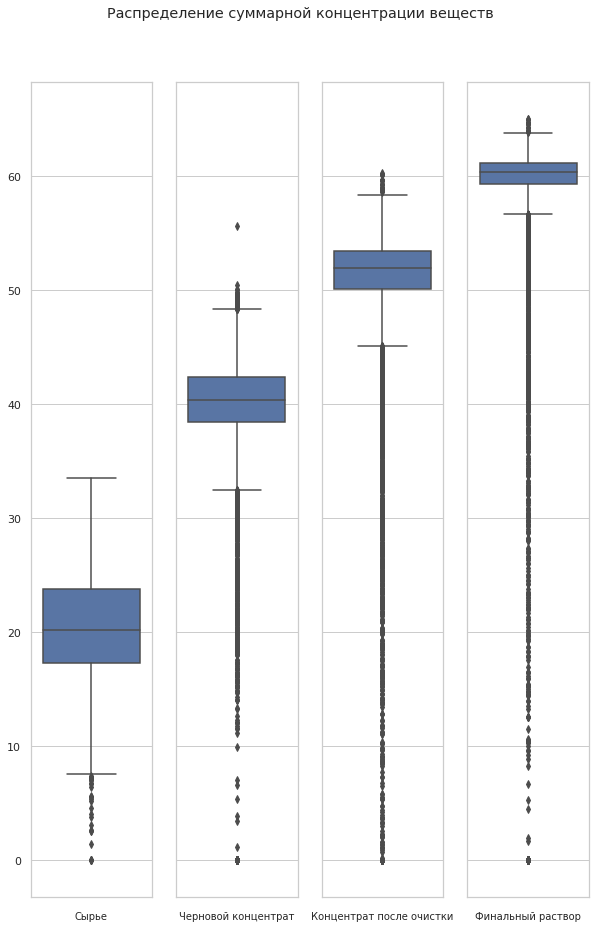

In [54]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(10,15))
sns.boxplot(y='rougher_input', data = full_rep, ax=ax[0])
ax[0].set_xlabel('Cырье', size=10)
ax[0].set_ylabel('')

sns.boxplot(y='rougher_output', data=full_rep, ax=ax[1])
ax[1].set_xlabel('Черновой концентрат', size =10)
ax[1].set_ylabel('')

sns.boxplot(y='primary_cleaner', data=full_rep, ax=ax[2])
ax[2].set_xlabel('Концентрат после очистки', size=10)
ax[2].set_ylabel('')

sns.boxplot(y='final', data=full_rep, ax=ax[3])
ax[3].set_xlabel('Финальный раствор', size=10)
ax[3].set_ylabel('')

plt.suptitle('Распределение суммарной концентрации веществ', y=0.95 )
plt.show()

На основании анализа данных можно заключить, что на всех этапах обработки наблюдаются выбросы.  

Напишем функцию для определения интервала, значения выходящие за пределы которого являются выбросами

In [55]:
def outliers(column):
    q1 = full_rep[column].quantile(0.25)
    q3 = full_rep[column].quantile(0.75)
    diff = q3 - q1
    left_int = np.where((q1 - 1.5*diff) > 0, q1 - 1.5*diff, 0)
    right_int = np.where((q3 + 1.5*diff) > 0, q3 + 1.5*diff, 0)
    return (left_int, right_int)

Определим границы интервала для сырья

In [56]:
rougher_input_range = outliers('rougher_input')
print(rougher_input_range)

(array(7.43612741), array(33.61413283))


Определим границы интервала для чернового концентрата

In [57]:
rougher_output = outliers('rougher_output')
print(rougher_output)

(array(32.43894475), array(48.3207957))


Определим границы интервала для концентрации после очистки

In [58]:
primary_cleaner = outliers('primary_cleaner')
print(primary_cleaner)

(array(45.05440055), array(58.38639653))


Определим границы интервала для финального раствора

In [59]:
final = outliers('final')
print(final)

(array(56.60080638), array(63.79418275))


Поскольку наибольшое скопление выбросов во всех датасетах наблюдается у нижнего уса, отсечем значения, выходящие за его пределы. 

In [60]:
full_rep_update = full_rep[(full_rep['rougher_input'] >= 7) & (full_rep['rougher_output'] > 32) & (full_rep['primary_cleaner'] > 45) & (full_rep['final'] > 56)]
full_rep_update.shape

(17011, 91)

Посмотрим на долю потерянных данных

In [61]:
miss_out_full = (len(full_rep) - len(full_rep_update))/len(full_rep)
print('Потери в данных составляют {:%}'.format(miss_out_full))

Потери в данных составляют 12.490354%


Произведем чистку выбросов в тестовой и обучающей выборках

In [62]:
train_rep_update = train_rep.query('index in @full_rep_update.index')
test_rep_update = test_rep.query('index in @full_rep_update.index')

Потери обучающей выборки

In [63]:
miss_out_train = (len(train_rep) - len(train_rep_update))/len(train_rep)
print('Потери в данных составляют {:%}'.format(miss_out_train))

Потери в данных составляют 12.806559%


Потери тестовой выборки

In [64]:
miss_out_test = (len(test_rep) - len(test_rep_update))/len(test_rep)
print('Потери в данных составляют {:%}'.format(miss_out_test))

Потери в данных составляют 11.644612%


In [65]:
train_rep_update.shape

(12337, 55)

Выводы по результатам анализа данных: 

- Концентрация металлов (Au, Ag, Pb) меняется на различных этапах.
- Концентрация серебра (Ag) на каждом этапе очистки снижается, при этом она достигает максимальной концентрации на втором этапе технологического процесса. На последнем этапе концентрация ниже, чем на первом этапе.
- Концентрация золота (Au) с каждым последующим этапом технологического процесса увеличивается. Самая высокая концентрация наблюдается на последнем этапе. У распределения концентрации золота тяжелые хвосты, что указывает на большое количество выбросов. 
- Концентрация свинца (Pb) с каждым последующим этапом увеличивается. На финальной стадии технологического процесса сокращается разрбос значений свинца. 
- Распределение размера гранул на обучающей и тестовой выборках не отличается значительно друг от друга, что позволяет нам использовать выборки для оценки моделей. 
- В данных суммарной концентрации металлов на четырех этапах технологического процесса были обнаружены и удалены аномально низкие значения. 

## 3. Модель
<a name="paragraph3"></a>

### 3.1 Написание функции для расчета sMAPE
<a name="subparagraph10"></a>

$$ sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} × 100% $$

In [66]:
def smape(target, predictions):
    numenator = np.abs(target - predictions)
    denominator = (np.abs(target) + np.abs(predictions))/2
    smape = 1/len(target) * ((numenator / denominator).sum())*100
    return smape

$$ sMAPE final = 0.25 × sMAPE(rougher) + 0.75 × sMAPE(final)$$

In [67]:
def smape_final(rougher_smape, smape_final):
    smape_final = 0.25*rougher_smape + 0.75*smape_final
    return smape_final

### 3.2 Обучение и оценка качества моделей
<a name="subparagraph11"></a>

Обучим разные модели и оценим качество кросс-валидацией. Выберем лучшую модель и проверим ее на тестовой выборке. 

Выборка на обучающих данных

In [68]:
rougher_target_train =train_rep_update['rougher.output.recovery']
output_target_train = train_rep_update['final.output.recovery']
features_train = train_rep_update.drop(['date_time', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

Выборка на тестовых данных

In [69]:
rougher_target_test = test_rep_update['rougher.output.recovery']
output_target_test = test_rep_update['final.output.recovery']
features_test = test_rep_update.drop(['date_time', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

Произведем масштабирование признаков на обучающей и тестовой выборках с использованием метода StandardScaler

In [70]:
feat = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[feat])

features_train[feat] = scaler.transform(features_train[feat])
features_test[feat] = scaler.transform(features_test[feat])

Для дальнейшего тестирования моделей методом кросс-валидацией создадим собственный scorer, который рассчитывает smape с помощью метода SMAPE.

In [71]:
smape_score = make_scorer(smape)

Будем оценивать модели решающего дерева, случайного леса и линейной регрессии. 

In [72]:
random_state = 12345
cv = 5
models = [DecisionTreeRegressor(random_state = random_state), 
          RandomForestRegressor(random_state = random_state), 
          LinearRegression()]

In [73]:
import warnings
warnings.simplefilter('ignore')
results = []

for model in models: 
    
    scorer = smape_score 
    
    cross_val_score_rougher = cross_val_score(model, 
                                              features_train, 
                                              rougher_target_train, 
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_output = cross_val_score(model, 
                                            features_train, 
                                            output_target_train, 
                                            cv=cv, scoring=scorer).mean()

    results.append({'model': model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_output}) 
              
pd.DataFrame(results)

,model,cross_val_score_rougher,cross_val_score_final
0,DecisionTreeRegressor,9.112011,13.980868
1,RandomForestRegressor,6.632453,9.425841
2,LinearRegression,7.086505,10.668091


Лучший результат демонстрирует модель случайного леса. Подберем гиперпараметры, демонстрирующие наилучшие результаты для данной модели.

In [ ]:
%%time
results_1 = []

for depth in range (1, 5):
    for est in range (5, 20, 5):
        model = RandomForestRegressor(random_state = random_state, n_estimators = est, max_depth = depth)
        scorer = make_scorer(smape)
        
        cross_val_score_rougher = cross_val_score(model, features_train, rougher_target_train, cv=cv, scoring=scorer).mean()
        cross_val_score_output = cross_val_score(model, features_train, output_target_train, cv=cv, scoring=scorer).mean()
        
        smape_final_result = smape_final(cross_val_score_rougher, cross_val_score_output)
        results_1.append({'model': model.__class__.__name__, 
                        'Hyperparameters': {'random_state': random_state, 
                                            'n_estimators': est, 
                                            'max_depth':depth}, 
                        'smape_final_result': smape_final_result})
pd.DataFrame(results_1)

Наилучшая модель случайного леса характеризуется следующими гиперпараметрами: количество деревьев - 15, глубина - 4. 

### 3.3 Проверка модели на тестовой выборке
<a name="subparagraph12"></a>

Обучим модель случайного леса с параметрами n_estimators = 15, max_depth = 4

In [ ]:
best_model = RandomForestRegressor(random_state=random_state, n_estimators = 15, max_depth = 4)

best_model.fit(features_train, rougher_target_train)
predictions_rougher = best_model.predict(features_test)

best_model.fit(features_train, output_target_train)
predictions_output = best_model.predict(features_test)

smape_tougher = smape(rougher_target_test, predictions_rougher)
smape_output = smape(output_target_test, predictions_output)

print('Final SMAPE:', smape_final(smape_tougher, smape_output))

### 3.4 Проверка модели на адекватность
<a name="subparagraph13"></a>

Для проверки модели на адекватность будем использовать DummyRegressor

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, rougher_target_train)
predictions_rougher_dummy = dummy_regr.predict(features_test)
dummy_regr.fit(features_train, output_target_train)
predictions_output_dummy = dummy_regr.predict(features_test)

In [ ]:
smape_rougher_constant = smape(rougher_target_test, predictions_rougher_dummy)
smape_output_dummy = smape(output_target_test, predictions_output_dummy)
print('Final SMAPE', smape_final(smape_rougher_constant, smape_output_dummy))

Таким образом, показатель SMAPE обученной модели на тестовой выборке лучше, чем SMAPE константной модели. В пером случае он составляет 6,6%, во втором случае - 7,1%. 

**Вывод** <br>
На этапе построения моделей: <br>
- написаны функции для расчета SMAPE и финального SMAPE;
- произведено сравнение кросс-валидацией трех моделей (DecisionTreeRegressor(), RandomForestRegressor, LinearRegression);
- протестировали модель случайного леса с наилучшим показателем SMAPE (с глубиной 4  и количеством деревьев, равным 15. 
- обученная модель случайного леса на тестовой выборке продемонстрировала результат лучше, чем константная модель (ошибка модели случайного леса 6,6%, константной модели - 7,1%) 

## 4. Общий вывод
<a name="paragraph4"></a>

В рамках данного проекта были произведены следующие шаги: <br>

1) На первом шаге: <br>
- произведена предобработка данных - заменены типы данных, проверены дубликаты; <br>
- проведен анализ признаков и подготовлена выборка для дальнейшей работы; <br>
- произведена проверка корректиности расчета показателя эффективности обогащения (убедилисть, что показатель рассчитан верно); <br>

2) На втором шаге: <br>
- проанализировано изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Концентрация металлов ведет себя по разному. Концетрация серебра с каждый последующим этапом падаем, а концентрация золота - напротив, увеличивается, концентрация свинца возрастает на первых трех этапах. <br>
- произведено сравнение распределения размер гранул на обучающей и тестовой выборках (сделан вывод о сходстве распределений, что позволяет использовать выборки для построения и оценки моделей) <br> 
- проанализирована суммарная концентрация всех металлов на различных стадиях технологического процесса, обнаружены и удалены аномально низкие значение концентрации во всех выборках <br> 

3) На третьем шаге (обучение модели): <br>
- написаны функции для расчета SMAPE и финального SMAPE; <br>
- произведено сравнение работы трех моделей: модели решающего дерева, модели случайного леса, линейной регрессии); <br>
- в качестве наилучшей модели отобрана модель случайного леса с 15 деревьями и глубиной, равной 4; <br>
- обученная модель продемострировала более низкую ошибку, чем константная модель: 6,6% против 7,1%. <br> 